## Librarys importeren

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.dummy import DummyClassifier
from copy import deepcopy

%run data-cleaning.ipynb

In [2]:
pd.set_option('display.max_columns', None)  # Toon alle kolommen
pd.set_option('display.max_rows', None)     # Toon alle rijen als dat nodig is
pd.set_option('display.max_colwidth', None) # Toon volledige inhoud van elke kolom
# df = pd.read_csv(r"C:\GitHub\jaar 2\blok 1\groeps project proraills\dataset-prorail-clean-3.csv") pc
# df = pd.read_csv(r"C:\GitHub\jaar 2\groeps project prorail\dataset-prorail-clean-3.csv") #laptop
df = pd.read_csv(r"dataset-prorail-clean-3.csv")
dfNotCleaned = deepcopy(df)
df = clean_data(df)
# dfNotCleaned.head()
df.head()

/tmp/ipykernel_868591/1365533468.py:6: DtypeWarning: Columns (0,7,16,25,30,31,42,44,46,48,58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"dataset-prorail-clean-3.csv")


,Unnamed: 0,stm_mon_nr,stm_sap_meld_ddt,stm_geo_mld,stm_km_van_mld,stm_km_tot_mld,stm_prioriteit,stm_aanngeb_ddt,stm_oh_pg_gst,stm_geo_gst,stm_km_van_gst,stm_km_tot_gst,stm_oorz_groep,stm_oorz_code,stm_afspr_aanvangddt,stm_fh_ddt,stm_fh_status,stm_sap_storeind_ddt,stm_tao_indicator,stm_tao_indicator_vorige,stm_tao_soort_mutatie,stm_tao_telling_mutatie,stm_tao_beinvloedbaar_indicator,stm_sap_melddatum,stm_sap_meldtijd,stm_contractgeb_mld,stm_techn_mld,stm_contractgeb_gst,stm_techn_gst,stm_aanngeb_dd,stm_aanngeb_tijd,stm_aanntpl_dd,stm_aanntpl_tijd,stm_progfh_in_datum,stm_progfh_in_tijd,stm_progfh_in_invoer_dat,stm_progfh_in_invoer_tijd,stm_progfh_in_duur,stm_progfh_gw_tijd,stm_progfh_gw_teller,stm_afspr_aanvangdd,stm_fh_dd,stm_fh_tijd,stm_fh_duur,stm_sap_storeinddatum,stm_sap_storeindtijd,stm_dstrglp_van,stm_dstrglp_naar,stm_aanntpl_ddt,duur_prog_fh
129628,144452,0.0,2014-06-10 12:29:00,63.0,4348.0,0.0,4.0,06/10/2014 12:37:00,26S,63.0,4350.0,0.0,TECHONV,215.0,NaN,06/10/2014 13:30:00,1.0,06/10/2014 13:30:00,N,NaN,NaN,0,B,06/10/2014,12:29:00,26.0,S,26.0,S,06/10/2014,12:37:00,06/10/2014,13:08:00,06/10/2014,13:39:00,06/10/2014,13:09:59,31,00:00:00,0.0,00/00/0000,06/10/2014,13:30:00,53.0,06/10/2014,13:30:00,NaN,NaN,06/10/2014 13:08:00,0 days 00:22:00
129629,144453,0.0,2014-06-10 12:29:00,63.0,4348.0,0.0,4.0,06/10/2014 12:37:00,26S,63.0,4350.0,0.0,TECHONV,215.0,NaN,06/10/2014 13:30:00,1.0,06/10/2014 13:30:00,N,N,NaN,0,B,06/10/2014,12:29:00,26.0,S,26.0,S,06/10/2014,12:37:00,06/10/2014,13:08:00,06/10/2014,13:39:00,06/10/2014,13:09:59,31,00:00:00,0.0,00/00/0000,06/10/2014,13:30:00,53.0,06/10/2014,13:30:00,NaN,NaN,06/10/2014 13:08:00,0 days 00:22:00
129630,144454,0.0,2014-06-10 12:38:00,557.0,27486.0,0.0,5.0,06/10/2014 12:47:00,18B,557.0,27486.0,0.0,TECHONV,218.0,NaN,06/10/2014 22:09:00,1.0,09/10/2014 07:15:00,N,NaN,NaN,0,B,06/10/2014,12:38:00,18.0,B,18.0,B,06/10/2014,12:47:00,06/10/2014,20:44:00,06/10/2014,22:09:00,06/10/2014,22:10:06,85,00:00:00,0.0,07/10/2014,06/10/2014,22:09:00,562.0,09/10/2014,07:15:00,NaN,NaN,06/10/2014 20:44:00,0 days 01:25:00
129631,144455,2725241.0,2014-06-10 13:08:00,817.0,114400.0,0.0,2.0,06/10/2014 13:21:00,18S,NaN,0.0,0.0,TECHONV,299.0,NaN,06/10/2014 13:54:00,2.0,22/10/2014 16:38:00,N,NaN,NaN,0,B,06/10/2014,13:08:00,18.0,S,18.0,S,06/10/2014,13:21:00,06/10/2014,13:44:00,06/10/2014,13:54:00,06/10/2014,14:52:24,10,00:00:00,0.0,00/00/0000,06/10/2014,13:54:00,33.0,22/10/2014,16:38:00,SLOE,LWD,06/10/2014 13:44:00,0 days 00:10:00
129632,144456,2725241.0,2014-06-10 13:08:00,817.0,114400.0,0.0,2.0,06/10/2014 13:21:00,18S,817.0,0.0,0.0,TECHONV,215.0,NaN,06/10/2014 13:54:00,2.0,22/10/2014 16:38:00,N,N,NaN,0,B,06/10/2014,13:08:00,18.0,S,18.0,S,06/10/2014,13:21:00,06/10/2014,13:44:00,06/10/2014,13:54:00,06/10/2014,14:52:24,10,00:00:00,0.0,00/00/0000,06/10/2014,13:54:00,33.0,22/10/2014,16:38:00,SLOE,LWD,06/10/2014 13:44:00,0 days 00:10:00


### Columns
Here you can find all the columns that we are thinking of using for our models.

1. stm_aanngeb_ddt: Contractor submission date - The date when the contractor submitted information for the incident.
2. stm_geo_gst: Geo-location - The geographical location of the incident or where the fault occurred.
3. stm_oorz_groep: Cause group - The broader category or group assigned to the cause of the incident or fault.
4. stm_afspr_aanvangddt: Agreed start date - The date agreed upon for starting the resolution of the incident or fault.
5. stm_sap_storeind_ddt: SAP store date - The date when the incident information was recorded in the SAP system.
6. stm_tao_indicator: Task assignment indicator - A status indicator showing whether a task has been assigned for the incident.
7. stm_tao_indicator_vorige: Previous task assignment indicator - The previous status of the task assignment indicator.
8. stm_tao_soort_mutatie: Type of mutation - The type of change or update applied to the task assignment or incident.
9. stm_contractgeb_mld: Reporting contract entity - The contract entity or organization responsible for the fault report.
10. stm_aanngeb_dd: Contractor submission date - The date when the contractor submitted details related to the task.
11. stm_aanntpl_dd: Tentative completion date - The expected date by which the task or incident is anticipated to be resolved.
12. stm_progfh_in_datum: Fault prognosis date - The date when the prognosis for the fault resolution was made.
13. stm_sap_storeinddatum: SAP storage date - The date when the incident information was stored in the SAP system.
14. stm_dstrglp_van: Disruption start - The starting point or time when the disruption related to the incident began.
15. stm_dstrglp_naar: Disruption end - The ending point or time when the disruption related to the incident ended.

## Data Analysis
In this section, we present the columns that have undergone cleaning. These are the columns we plan to use for model development. Additionally, some columns included here may not be used in the models but could still provide useful insights.

In [3]:
# Ensure all columns and rows are displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Calculate the total number of rows
total_rows = len(df)

# Create a DataFrame summarizing missing values
missing_values_summary = pd.DataFrame({
    'Column Name': df.columns,
    'Missing Values': df.isnull().sum(),
    'Total Values': total_rows
})

# Calculate the percentage of missing values and round it for readability
missing_values_summary['Percentage Missing'] = ((missing_values_summary['Missing Values'] / missing_values_summary['Total Values']) * 100).round(2)

# Filter to include only columns with missing values
missing_values_summary = missing_values_summary[missing_values_summary['Missing Values'] > 0]

# Print the summary in a more readable format
print("\nMissing Values Summary (Only Columns with Missing Values):\n")
print(missing_values_summary.to_string(index=False, col_space=20))


Missing Values Summary (Only Columns with Missing Values):

             Column Name       Missing Values         Total Values   Percentage Missing
         stm_aanngeb_ddt                   39               416038                 0.01
             stm_geo_gst                62901               416038                15.12
          stm_oorz_groep                    4               416038                 0.00
    stm_afspr_aanvangddt               379262               416038                91.16
           stm_fh_status                   51               416038                 0.01
    stm_sap_storeind_ddt                36491               416038                 8.77
       stm_tao_indicator                  781               416038                 0.19
stm_tao_indicator_vorige               277820               416038                66.78
   stm_tao_soort_mutatie               335462               416038                80.63
     stm_contractgeb_mld                  334              

We observe that several columns have a significant percentages of missing values, particularly `stm_tao_indicator_vorige` and `stm_tao_soort_mutatie`, which have missing rates of 79.30% and 83.18%, respectively. We are probably not going to use these columns because of the high amount of missing values, which could impact our model. Therefore, we may need to consider strategies for handling these missing values, such as replacing the missing values with the mean or removal of columns, depending on their relevance to our models.

## Graphs
We have made a graph here so that you can see what types of problems are in the database.

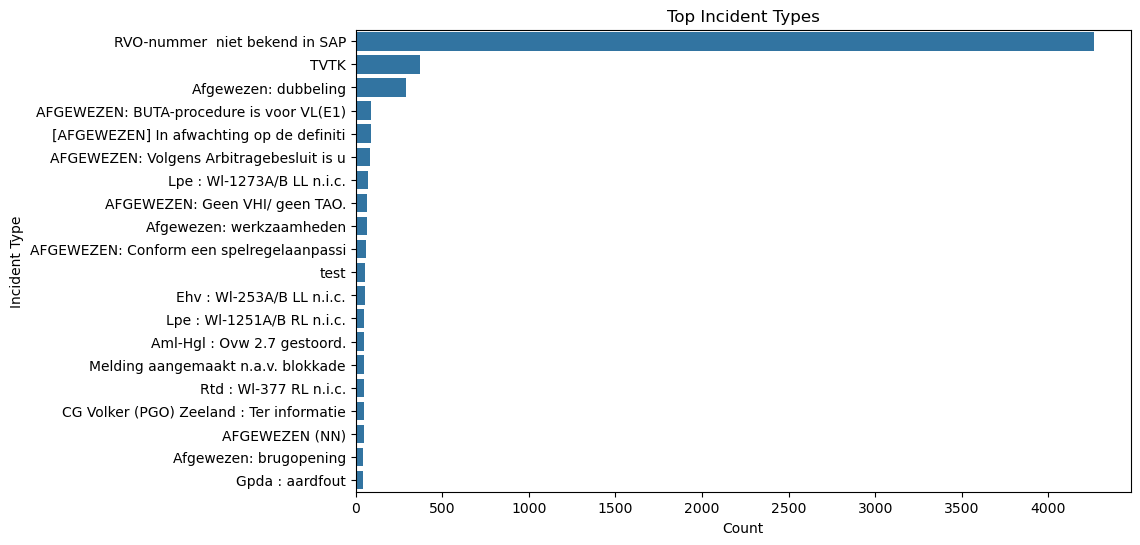

In [4]:
top_n = 20  # Adjust this number as needed
top_incidents = dfNotCleaned['stm_sap_meldtekst'].value_counts().nlargest(top_n)
plt.figure(figsize=(10, 6))
sns.barplot(y=top_incidents.index, x=top_incidents.values)
plt.title("Top Incident Types")
plt.xlabel("Count")
plt.ylabel("Incident Type")
plt.show()


As you can see, most of them are not known. We are not sure why this is. But since these are string values we can't use them in our model.

From now on we will use the fully cleaned data for further understanding and analysis. We will start by understanding the distribution of the data.

For now we will bin the duration it takes for "functie herstel" to take place using bins of equal width (except the first 2). We do this because these will be the classes we will try to predict. 

Eventually we wan't to use frequancy binning so the first few bins can be predicted more accurately. (accuracy in the sense of less time span)

['5.00 - 14.00', '14.00 - 24.98', '24.98 - 37.00', '37.00 - 49.00', '49.00 - 62.03', '62.03 - 88.00', '88.00 - 126.98', '126.98 - 169.25', '169.25 - 224.00', '224.00 - 277.93', '277.93 - 375.00', '375.00 - 480.00']
[  300.     840.    1499.    2220.    2940.    3722.1   5280.    7619.
 10155.   13440.   16675.56 22500.   28800.  ]


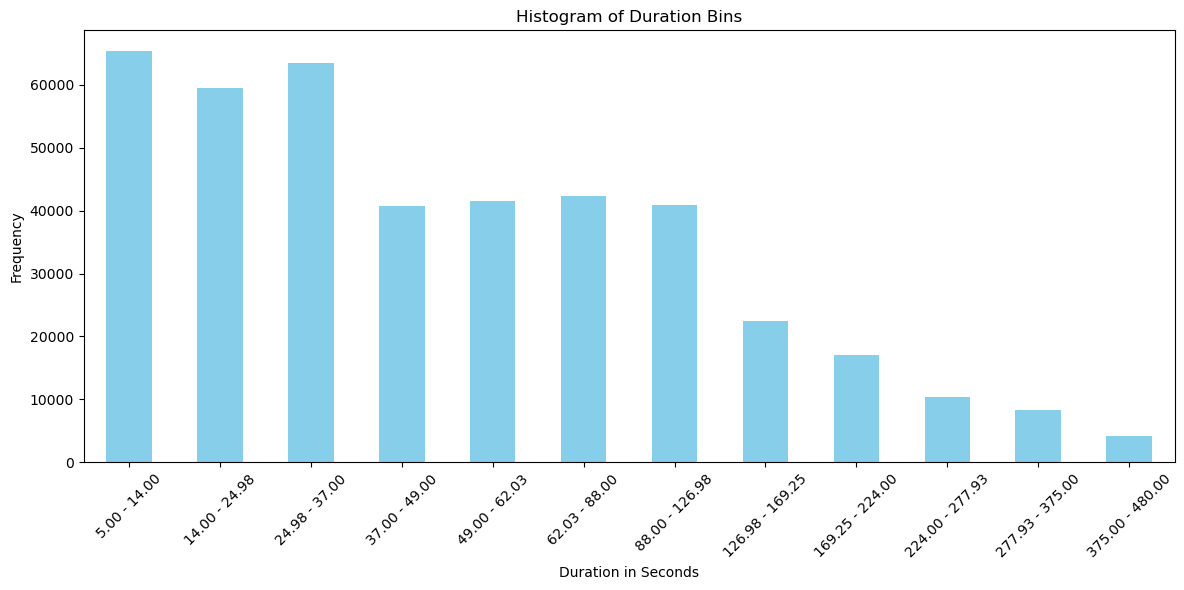

In [5]:
df['duur_prog_fh_seconds'] = df['duur_prog_fh'].dt.total_seconds()
num_bins = [0.0, 0.15, 0.3, 0.45, 0.55, 0.65, 0.75, 0.85, 0.904, 0.945, 0.97, 0.99, 1.0]
df, bin_edges = create_bins(df, 'duur_prog_fh_seconds', num_bins)

# Get the frequency of each bin
bin_counts = df['duur_prog_fh_seconds_bins'].value_counts().sort_index()

# Create labels for each bin
bin_labels = [f'{bin_edges[i]/60:.2f} - {bin_edges[i+1]/60:.2f}' for i in range(len(bin_edges)-1)]
print(bin_labels)
print(bin_edges)

# Plot the histogram
plt.figure(figsize=(12, 6))
bin_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Duration in Seconds')
plt.ylabel('Frequency')
plt.title('Histogram of Duration Bins')
plt.xticks(ticks=range(len(num_bins)-1), labels=bin_labels, rotation=45)
plt.tight_layout()
plt.show()

# Convert stm_fh_duur to numeric, setting errors='coerce' will replace non-numeric values with NaN
df['stm_fh_duur'] = pd.to_numeric(df['stm_fh_duur'], errors='coerce')

# Bereken de maximale waarde in de kolom
max_value = df['stm_fh_duur'].max(skipna=True)

# Bereken het aantal bins van 30
bin_size = 30
# num_bins = (max_value // bin_size) + 1  # Aantal bins, voeg 1 toe voor het 0-interval


We have chosen to display the time this way so that we can make better estimates for shorter problems. Since most issues are brief, we believe this is the best approach.

Below, we have provided a correlation table so that you can easily see the correlation between the columns that we may use for our models.

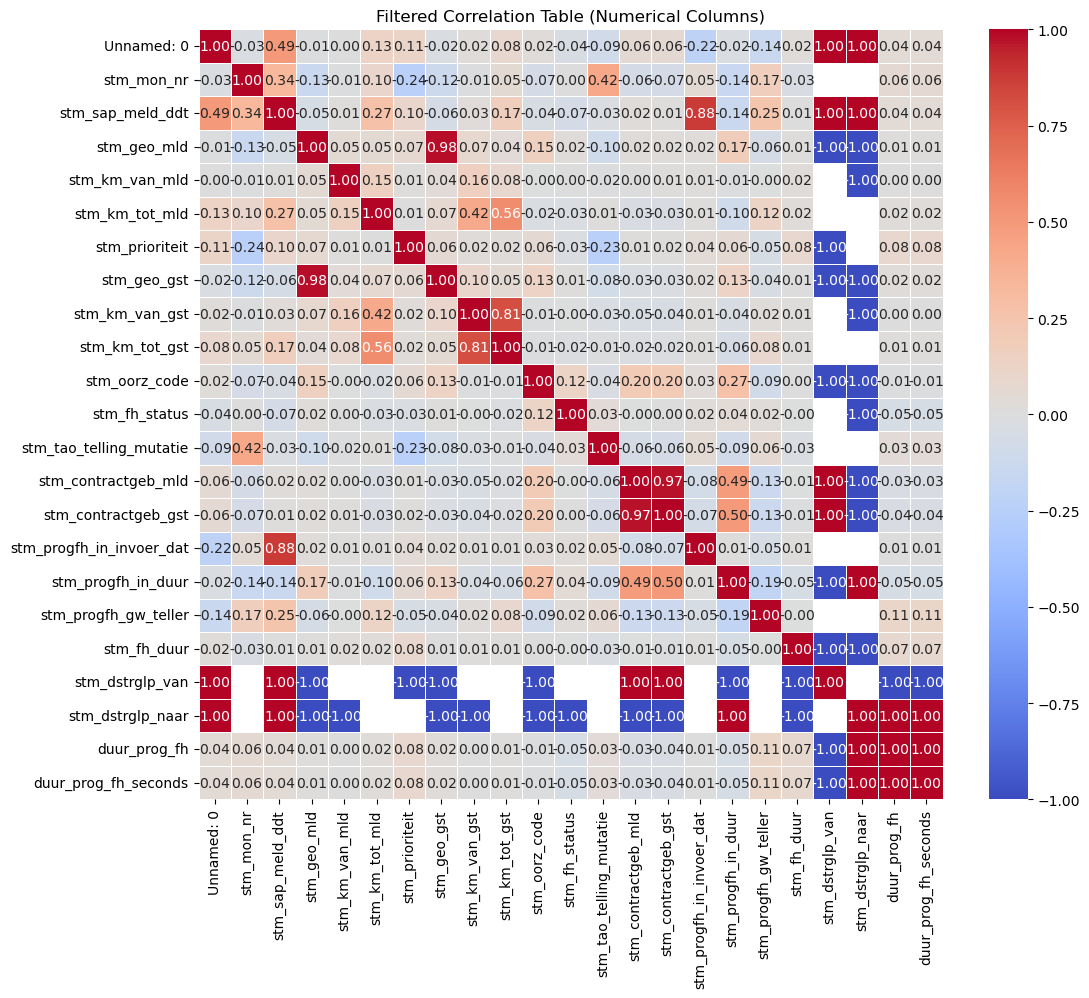

In [6]:
# Probeer zoveel mogelijk kolommen om te zetten naar numeriek en retourneer een nieuwe DataFrame
def convert_to_numeric(df):
    new_df = df.copy()  # Maak een kopie van de originele DataFrame
    for column in new_df.columns:
        # Probeer elke kolom om te zetten naar een numeriek type
        new_df[column] = pd.to_numeric(new_df[column], errors='coerce')
    return new_df

# Converteer alle kolommen naar numeriek waar mogelijk en maak een nieuwe DataFrame
numeric_df = convert_to_numeric(df)

# Selecteer alleen numerieke kolommen voor de correlatiematrix
numeric_df_filtered = numeric_df.select_dtypes(include=['number'])

# Verwijder kolommen met constante waarden
numeric_df_filtered = numeric_df_filtered.loc[:, (numeric_df_filtered != numeric_df_filtered.iloc[0]).any()]

# Bereken de correlatiematrix op de gefilterde gegevens
correlation_table = numeric_df_filtered.corr()

# Filter de correlatiematrix op een correlatiedrempel (bijv. 0.1)
threshold = 0.1
correlation_table_filtered = correlation_table[(correlation_table.abs() >= threshold).any(axis=1)]
correlation_table_filtered = correlation_table_filtered.loc[:, (correlation_table_filtered.abs() >= threshold).any(axis=0)]

# Controleer of er gegevens zijn om te plotten
if not correlation_table_filtered.empty:
    # Plot de gefilterde correlatiematrix met minder decimalen
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_table_filtered, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
    plt.title('Filtered Correlation Table (Numerical Columns)')
    plt.show()
else:
    print("Geen relevante correlaties om te plotten.")


As you can see, there are some columns that correlate with each other, but most importantly is the correlation with `stm_fh_duur` since this is our target variable. With this one only 2 are midly correlated, which are `stm_dstrglp_naar` and `stm_prioriteit`.

## Baseline
Below, we have created the baseline that we can use for comparison with our models.

In [7]:
# convert to numeric
df['stm_progfh_in_duur'] = pd.to_numeric(df['stm_progfh_in_duur'], errors="coerce")
df.dropna(subset=['stm_progfh_in_duur'], inplace=True)

df['stm_fh_duur'] = pd.to_numeric(df['stm_fh_duur'], errors="coerce")
df.dropna(subset=['stm_fh_duur'], inplace=True)

# Convert the bin edges to minutes
bin_edges_min=bin_edges/60
# Add 1 to the last bin edge to include the maximum value
bin_edges_min[-1] = bin_edges_min[-1] + 1

# Create labels for each bin
df = df[((5 <= df['stm_progfh_in_duur']) & (df['stm_progfh_in_duur'] <= 60*8))]
df = df[((5 <= df['stm_fh_duur']) & (df['stm_fh_duur'] <= 60*8))]

# Create labels for each bin
df['stm_progfh_in_duur_bins'] = np.digitize(df['stm_progfh_in_duur'], bin_edges_min)
df['stm_progfh_in_duur_bins_label'] = df['stm_progfh_in_duur_bins'].apply(lambda x: bin_labels[x - 1])

df['stm_fh_duur_bins'] = np.digitize(df['stm_fh_duur'], bin_edges_min)
df['stm_fh_duur_bins_label'] = df['stm_fh_duur_bins'].apply(lambda x: bin_labels[x - 1])

#baseline model
print("accuracy:", (df['stm_progfh_in_duur_bins_label']==df['stm_fh_duur_bins_label']).sum()/len(df))

accuracy: 0.19662881392095968


As you can see we achieve a baseline accuracy of about `19.6%`.